# Build a Retrieval Augmented Generation (RAG) App: Part 1

One of the most powerful applications enabled by LLMs is sophisticated question-answering (Q&A) chatbots. These are applications that can answer questions about specific source information. These applications use a technique known as Retrieval Augmented Generation, or [RAG](/docs/concepts/rag/).

This is a multi-part tutorial:

- [Part 1](/docs/tutorials/rag) (this guide) introduces RAG and walks through a minimal implementation.
- [Part 2](/docs/tutorials/qa_chat_history) extends the implementation to accommodate conversation-style interactions and multi-step retrieval processes.

This tutorial will show how to build a simple Q&A application
over a text data source. Along the way we’ll go over a typical Q&A
architecture and highlight additional resources for more advanced Q&A techniques. We’ll also see
how LangSmith can help us trace and understand our application.
LangSmith will become increasingly helpful as our application grows in
complexity.

If you're already familiar with basic retrieval, you might also be interested in
this [high-level overview of different retrieval techniques](/docs/concepts/retrieval).

**Note**: Here we focus on Q&A for unstructured data. If you are interested for RAG over structured data, check out our tutorial on doing [question/answering over SQL data](/docs/tutorials/sql_qa).

## Overview
A typical RAG application has two main components:

**Indexing**: a pipeline for ingesting data from a source and indexing it. *This usually happens offline.*

**Retrieval and generation**: the actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.

Note: the indexing portion of this tutorial will largely follow the [semantic search tutorial](/docs/tutorials/retrievers).

The most common full sequence from raw data to answer looks like:

### Indexing
1. **Load**: First we need to load our data. This is done with [Document Loaders](/docs/concepts/document_loaders).
2. **Split**: [Text splitters](/docs/concepts/text_splitters) break large `Documents` into smaller chunks. This is useful both for indexing data and passing it into a model, as large chunks are harder to search over and won't fit in a model's finite context window.
3. **Store**: We need somewhere to store and index our splits, so that they can be searched over later. This is often done using a [VectorStore](/docs/concepts/vectorstores) and [Embeddings](/docs/concepts/embedding_models) model.

![index_diagram](https://github.com/langchain-ai/langchain/blob/master/docs/static/img/rag_indexing.png?raw=1)

### Retrieval and generation
4. **Retrieve**: Given a user input, relevant splits are retrieved from storage using a [Retriever](/docs/concepts/retrievers).
5. **Generate**: A [ChatModel](/docs/concepts/chat_models) / [LLM](/docs/concepts/text_llms) produces an answer using a prompt that includes both the question with the retrieved data

![retrieval_diagram](https://github.com/langchain-ai/langchain/blob/master/docs/static/img/rag_retrieval_generation.png?raw=1)

Once we've indexed our data, we will use [LangGraph](https://langchain-ai.github.io/langgraph/) as our orchestration framework to implement the retrieval and generation steps.

## Setup

### Jupyter Notebook

This and other tutorials are perhaps most conveniently run in a [Jupyter notebooks](https://jupyter.org/). Going through guides in an interactive environment is a great way to better understand them. See [here](https://jupyter.org/install) for instructions on how to install.

### Installation

This tutorial requires these langchain dependencies:

import Tabs from '@theme/Tabs';
import TabItem from '@theme/TabItem';
import CodeBlock from "@theme/CodeBlock";

<Tabs>
  <TabItem value="pip" label="Pip" default>
  

In [5]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.7 MB/s eta 0:00:00


In [3]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass(prompt = "OpenAI Key: ")

OpenAI Key: ··········


  </TabItem>
  <TabItem value="conda" label="Conda">
    <CodeBlock language="bash">conda install langchain-text-splitters langchain-community langgraph -c conda-forge</CodeBlock>
  </TabItem>
</Tabs>


For more details, see our [Installation guide](/docs/how_to/installation).

### LangSmith

Many of the applications you build with LangChain will contain multiple steps with multiple invocations of LLM calls.
As these applications get more complex, it becomes crucial to be able to inspect what exactly is going on inside your chain or agent.
The best way to do this is with [LangSmith](https://smith.langchain.com).

After you sign up at the link above, make sure to set your environment variables to start logging traces:

```shell
export LANGSMITH_TRACING="true"
export LANGSMITH_API_KEY="..."
```

Or, if in a notebook, you can set them with:

```python
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()
```

## Components

We will need to select three components from LangChain's suite of integrations.

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs customVarName="llm" />

In [6]:
# | output: false
# | echo: false

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

import EmbeddingTabs from "@theme/EmbeddingTabs";

<EmbeddingTabs/>

In [7]:
# | output: false
# | echo: false

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

import VectorStoreTabs from "@theme/VectorStoreTabs";

<VectorStoreTabs/>

In [8]:
# | output: false
# | echo: false

from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

## Preview

In this guide we’ll build an app that answers questions about the website's content. The specific website we will use is the [LLM Powered Autonomous
Agents](https://lilianweng.github.io/posts/2023-06-23-agent/) blog post
by Lilian Weng, which allows us to ask questions about the contents of
the post.

We can create a simple indexing pipeline and RAG chain to do this in ~50
lines of code.

```python
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()
```

```python
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])
```

```
Task Decomposition is the process of breaking down a complicated task into smaller, manageable steps to facilitate easier execution and understanding. Techniques like Chain of Thought (CoT) and Tree of Thoughts (ToT) guide models to think step-by-step, allowing them to explore multiple reasoning possibilities. This method enhances performance on complex tasks and provides insight into the model's thinking process.
```

Check out the [LangSmith
trace](https://smith.langchain.com/public/65030797-7efa-4356-a7bd-b54b3dc70e17/r).

## Detailed walkthrough

Let’s go through the above code step-by-step to really understand what’s
going on.

## 1. Indexing {#indexing}

:::note

This section is an abbreviated version of the content in the [semantic search tutorial](/docs/tutorials/retrievers).
If you're comfortable with [document loaders](/docs/concepts/document_loaders), [embeddings](/docs/concepts/embedding_models), and [vector stores](/docs/concepts/vectorstores),
feel free to skip to the next section on [retrieval and generation](/docs/tutorials/rag/#orchestration).

:::

### Loading documents

We need to first load the blog post contents. We can use
[DocumentLoaders](/docs/concepts/document_loaders)
for this, which are objects that load in data from a source and return a
list of
[Document](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html)
objects.

In this case we’ll use the
[WebBaseLoader](/docs/integrations/document_loaders/web_base),
which uses `urllib` to load HTML from web URLs and `BeautifulSoup` to
parse it to text. We can customize the HTML -\> text parsing by passing
in parameters into the `BeautifulSoup` parser via `bs_kwargs` (see
[BeautifulSoup
docs](https://beautiful-soup-4.readthedocs.io/en/latest/#beautifulsoup)).
In this case only HTML tags with class “post-content”, “post-title”, or
“post-header” are relevant, so we’ll remove all others.

In [9]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43130


In [10]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


#### Go deeper

`DocumentLoader`: Object that loads data from a source as list of `Documents`.

- [Docs](/docs/how_to#document-loaders):
  Detailed documentation on how to use `DocumentLoaders`.
- [Integrations](/docs/integrations/document_loaders/): 160+
  integrations to choose from.
- [Interface](https://python.langchain.com/api_reference/core/document_loaders/langchain_core.document_loaders.base.BaseLoader.html):
  API reference for the base interface.

### Splitting documents

Our loaded document is over 42k characters which is too long to fit
into the context window of many models. Even for those models that could
fit the full post in their context window, models can struggle to find
information in very long inputs.

To handle this we’ll split the `Document` into chunks for embedding and
vector storage. This should help us retrieve only the most relevant parts
of the blog post at run time.

As in the [semantic search tutorial](/docs/tutorials/retrievers), we use a
[RecursiveCharacterTextSplitter](/docs/how_to/recursive_text_splitter),
which will recursively split the document using common separators like
new lines until each chunk is the appropriate size. This is the
recommended text splitter for generic text use cases.

In [11]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


#### Go deeper

`TextSplitter`: Object that splits a list of `Document`s into smaller
chunks. Subclass of `DocumentTransformer`s.

- Learn more about splitting text using different methods by reading the [how-to docs](/docs/how_to#text-splitters)
- [Code (py or js)](/docs/integrations/document_loaders/source_code)
- [Scientific papers](/docs/integrations/document_loaders/grobid)
- [Interface](https://python.langchain.com/api_reference/text_splitters/base/langchain_text_splitters.base.TextSplitter.html): API reference for the base interface.

`DocumentTransformer`: Object that performs a transformation on a list
of `Document` objects.

- [Docs](/docs/how_to#text-splitters): Detailed documentation on how to use `DocumentTransformers`
- [Integrations](/docs/integrations/document_transformers/)
- [Interface](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.transformers.BaseDocumentTransformer.html): API reference for the base interface.

### Storing documents

Now we need to index our 66 text chunks so that we can search over them
at runtime. Following the [semantic search tutorial](/docs/tutorials/retrievers),
our approach is to [embed](/docs/concepts/embedding_models/) the contents of each document split and insert these embeddings
into a [vector store](/docs/concepts/vectorstores/). Given an input query, we can then use
vector search to retrieve relevant documents.

We can embed and store all of our document splits in a single command
using the vector store and embeddings model selected at the [start of the tutorial](/docs/tutorials/rag/#components).

In [12]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['6f7ce45e-b28e-4bd0-968e-7adb239658a1', '0605bc93-bf2b-45db-8e70-a273af7d7961', '83a85724-5296-4b36-b4a1-e97ff55cf72f']


#### Go deeper

`Embeddings`: Wrapper around a text embedding model, used for converting
text to embeddings.

- [Docs](/docs/how_to/embed_text): Detailed documentation on how to use embeddings.
- [Integrations](/docs/integrations/text_embedding/): 30+ integrations to choose from.
- [Interface](https://python.langchain.com/api_reference/core/embeddings/langchain_core.embeddings.Embeddings.html): API reference for the base interface.

`VectorStore`: Wrapper around a vector database, used for storing and
querying embeddings.

- [Docs](/docs/how_to/vectorstores): Detailed documentation on how to use vector stores.
- [Integrations](/docs/integrations/vectorstores/): 40+ integrations to choose from.
- [Interface](https://python.langchain.com/api_reference/core/vectorstores/langchain_core.vectorstores.base.VectorStore.html): API reference for the base interface.

This completes the **Indexing** portion of the pipeline. At this point
we have a query-able vector store containing the chunked contents of our
blog post. Given a user question, we should ideally be able to return
the snippets of the blog post that answer the question.

## 2. Retrieval and Generation {#orchestration}

Now let’s write the actual application logic. We want to create a simple
application that takes a user question, searches for documents relevant
to that question, passes the retrieved documents and initial question to
a model, and returns an answer.

For generation, we will use the chat model selected at the [start of the tutorial](/docs/tutorials/rag/#components).

We’ll use a prompt for RAG that is checked into the LangChain prompt hub
([here](https://smith.langchain.com/hub/rlm/rag-prompt)).

In [13]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


We'll use [LangGraph](https://langchain-ai.github.io/langgraph/) to tie together the retrieval and generation steps into a single application. This will bring a number of benefits:

- We can define our application logic once and automatically support multiple invocation modes, including streaming, async, and batched calls.
- We get streamlined deployments via [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/).
- LangSmith will automatically trace the steps of our application together.
- We can easily add key features to our application, including [persistence](https://langchain-ai.github.io/langgraph/concepts/persistence/) and [human-in-the-loop approval](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/), with minimal code changes.

To use LangGraph, we need to define three things:

1. The state of our application;
2. The nodes of our application (i.e., application steps);
3. The "control flow" of our application (e.g., the ordering of the steps).

#### State:

The [state](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a `TypedDict`, but can also be a [Pydantic BaseModel](https://langchain-ai.github.io/langgraph/how-tos/state-model/).

For a simple RAG application, we can just keep track of the input question, retrieved context, and generated answer:

In [14]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

#### Nodes (application steps)

Let's start with a simple sequence of two steps: retrieval and generation.

In [15]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Our retrieval step simply runs a similarity search using the input question, and the generation step formats the retrieved context and original question into a prompt for the chat model.

#### Control flow

Finally, we compile our application into a single `graph` object. In this case, we are just connecting the retrieval and generation steps into a single sequence.

In [16]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

LangGraph also comes with built-in utilities for visualizing the control flow of your application:

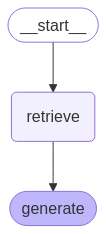

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

<details>
<summary>Do I need to use LangGraph?</summary>

LangGraph is not required to build a RAG application. Indeed, we can implement the same application logic through invocations of the individual components:

```python
question = "..."

retrieved_docs = vector_store.similarity_search(question)
docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
prompt = prompt.invoke({"question": question, "context": docs_content})
answer = llm.invoke(prompt)
```

The benefits of LangGraph include:

- Support for multiple invocation modes: this logic would need to be rewritten if we wanted to stream output tokens, or stream the results of individual steps;
- Automatic support for tracing via [LangSmith](https://docs.smith.langchain.com/) and deployments via [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/);
- Support for persistence, human-in-the-loop, and other features.

Many use-cases demand RAG in a conversational experience, such that a user can receive context-informed answers via a stateful conversation. As we will see in [Part 2](/docs/tutorials/qa_chat_history) of the tutorial, LangGraph's management and persistence of state simplifies these applications enormously.

</details>

#### Usage

Let's test our application! LangGraph supports multiple invocation modes, including sync, async, and streaming.

Invoke:

In [18]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='83a85724-5296-4b36-b4a1-e97ff55cf72f', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='5d5f400a-0a49-4dab-b14e-914179c5fa8e', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT b

Stream steps:

In [19]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='83a85724-5296-4b36-b4a1-e97ff55cf72f', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='5d5f400a-0a49-4dab-b14e-914179c5fa8e', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 202

Stream [tokens](/docs/concepts/tokens/):

In [20]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| decomposition| is| the| process| of| breaking| down| a| complex| task| into| smaller|,| manageable| steps|.| It| enhances| model| performance| by| allowing| the| model| to| think| step| by| step|,| utilizing| techniques| like| Chain| of| Thought| (|Co|T|)| and| Tree| of| Thoughts| to| structure| reasoning|.| This| approach| can| be| applied| through| simple| prompting|,| task|-specific| instructions|,| or| human| input|.||

:::tip

For async invocations, use:

```python
result = await graph.ainvoke(...)
```

and

```python
async for step in graph.astream(...):
```

:::

#### Returning sources

Note that by storing the retrieved context in the state of the graph, we recover sources for the model's generated answer in the `"context"` field of the state. See [this guide](/docs/how_to/qa_sources/) on returning sources for more detail.

#### Go deeper

[Chat models](/docs/concepts/chat_models) take in a sequence of messages and return a message.

- [Docs](/docs/how_to#chat-models)
- [Integrations](/docs/integrations/chat/): 25+ integrations to choose from.
- [Interface](https://python.langchain.com/api_reference/core/language_models/langchain_core.language_models.chat_models.BaseChatModel.html): API reference for the base interface.

**Customizing the prompt**

As shown above, we can load prompts (e.g., [this RAG
prompt](https://smith.langchain.com/hub/rlm/rag-prompt)) from the prompt
hub. The prompt can also be easily customized. For example:

In [21]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

## Query analysis

So far, we are executing the retrieval using the raw input query. However, there are some advantages to allowing a model to generate the query for retrieval purposes. For example:

- In addition to semantic search, we can build in structured filters (e.g., "Find documents since the year 2020.");
- The model can rewrite user queries, which may be multifaceted or include irrelevant language, into more effective search queries.

[Query analysis](/docs/concepts/retrieval/#query-analysis) employs models to transform or construct optimized search queries from raw user input. We can easily incorporate a query analysis step into our application. For illustrative purposes, let's add some metadata to the documents in our vector store. We will add some (contrived) sections to the document which we can filter on later.

In [22]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

We will need to update the documents in our vector store. We will use a simple [InMemoryVectorStore](https://python.langchain.com/api_reference/core/vectorstores/langchain_core.vectorstores.in_memory.InMemoryVectorStore.html) for this, as we will use some of its specific features (i.e., metadata filtering). Refer to the vector store [integration documentation](/docs/integrations/vectorstores/) for relevant features of your chosen vector store.

In [23]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

Let's next define a schema for our search query. We will use [structured output](/docs/concepts/structured_outputs/) for this purpose. Here we define a query as containing a string query and a document section (either "beginning", "middle", or "end"), but this can be defined however you like.

In [24]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

Finally, we add a step to our LangGraph application to generate a query from the user's raw input:

In [27]:
class State(TypedDict):
    question: str
    # highlight-next-line
    query: Search
    context: List[Document]
    answer: str


# highlight-next-line
def analyze_query(state: State):
    # highlight-next-line
    structured_llm = llm.with_structured_output(Search)
    # highlight-next-line
    query = structured_llm.invoke(state["question"])
    # highlight-next-line
    return {"query": query}


def retrieve(state: State):
    # highlight-start
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    # highlight-end
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# highlight-start
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
# highlight-end
graph = graph_builder.compile()

<details>
<summary>Full Code:</summary>

```python
from typing import Literal

import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import Annotated, List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)


# Update metadata (illustration purposes)
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


# Index chunks
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)


# Define schema for search
class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()
```

</details>

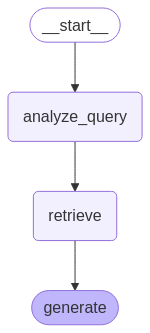

In [28]:
display(Image(graph.get_graph().draw_mermaid_png()))

We can test our implementation by specifically asking for context from the end of the post. Note that the model includes different information in its answer.

In [29]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'end of the post about Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='b7b0b076-42a5-4fcc-8a66-ccff338f530f', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 39220, 'section': 'end'}, page_content='Finite context length: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses. The design of the system has to work with this limited communication bandwidth, while mechanisms like self-reflection to learn from past mistakes would benefit a lot from long or infinite context windows. Although vector stores and retrieval can provide access to a larger knowledge pool, their representation power is not as powerful as full attention.\n\n\nChallenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring the solution space remain challenging

In both the streamed steps and the [LangSmith trace](https://smith.langchain.com/public/bdbaae61-130c-4338-8b59-9315dfee22a0/r), we can now observe the structured query that was fed into the retrieval step.

Query Analysis is a rich problem with a wide range of approaches. Refer to the [how-to guides](/docs/how_to/#query-analysis) for more examples.

## Next steps

We've covered the steps to build a basic Q&A app over data:

- Loading data with a [Document Loader](/docs/concepts/document_loaders)
- Chunking the indexed data with a [Text Splitter](/docs/concepts/text_splitters) to make it more easily usable by a model
- [Embedding the data](/docs/concepts/embedding_models) and storing the data in a [vectorstore](/docs/how_to/vectorstores)
- [Retrieving](/docs/concepts/retrievers) the previously stored chunks in response to incoming questions
- Generating an answer using the retrieved chunks as context.

In [Part 2](/docs/tutorials/qa_chat_history) of the tutorial, we will extend the implementation here to accommodate conversation-style interactions and multi-step retrieval processes.

Further reading:

- [Return sources](/docs/how_to/qa_sources): Learn how to return source documents
- [Streaming](/docs/how_to/streaming): Learn how to stream outputs and intermediate steps
- [Add chat history](/docs/how_to/message_history): Learn how to add chat history to your app
- [Retrieval conceptual guide](/docs/concepts/retrieval): A high-level overview of specific retrieval techniques